In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys

% matplotlib notebook

In [2]:
def evaluate(k, M, files):
    n = 0
    for j, i in enumerate(M):
        topk = i.argsort()[-k:]

        if files[j][:6] in (files[index][:6] for index in topk):
            n += 1
            
    return n * 1.0 / len(files)

In [3]:
def compute_distance(x,y):
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    return np.linalg.norm(x-y)

In [4]:
def calculate_jain_results(cut, i):
    
    jain_base_dir = '/fileserver/nmec-handwriting/stil-writing-corpus-processed/'
    
    path = jain_base_dir + cut + '/FR-Comps'
    files = os.listdir(path)
    files.sort()
    
    the_file = files[0]
    metric=[]
    for the_file in files:
      filename = path + '/' + the_file
      corpfile = open(filename, 'r').read().splitlines()
      metricline = [np.array([corpline.split(' ')[1] for corpline in corpfile]).astype(np.float32)]
      metric += metricline
    metric = np.array(metric)
    F = -metric
    np.fill_diagonal(F, -1)
    
    return np.array([evaluate(k, F, files) for k in range(1, i + 1)])

## Get the results of the JAIN feature cuts and classification

In [5]:
cuts = np.array(['vertfeats','seamfeats','TASfeats'])
jain_base_dir = '/fileserver/nmec-handwriting/stil-writing-corpus-processed/'
results = np.array([calculate_jain_results(cut, 100) for cut in cuts])

## Get feature files from D-Script

In [6]:
feature_dir = '/fileserver/nmec-handwriting/localfeatures/nmec_bw_denoised_cc_deNNiam_fiel657_min500/'

files = os.listdir(feature_dir)
files.sort()

feature_map = []
for i,filename in enumerate(files):
    path = feature_dir + "/" + filename
    #if os.path.isfile(path) and ( '004.' in filename or '007.' in filename):
    if os.path.isfile(path):
        try:
            feature_map.append( np.load(path).mean(axis=0) )
        except:
            feature_map.append( np.ones([1,4096]) * sys.maxint)
        
feature_map = np.array(feature_map)

## Calculate Distances

In [7]:
metric = []
for i, image in enumerate(feature_map):
    metricline = [np.array([compute_distance(image, other) for other in feature_map])]
    metric += metricline

metric = np.array(metric)
F = -metric
np.fill_diagonal(F, -sys.maxint)

x = np.array([evaluate(k, F, files) for k in range(1, 101)], dtype=np.float32)

## Calculate Additional Distances

### Pat-Net Dirty

In [48]:
F = np.load('/fileserver/nmec-handwriting/localfeatures/nmec_dirty_patnet_ccs.npy')
files = os.listdir('/fileserver/nmec-handwriting/stil-writing-corpus-processed/binary/FR/')
files.sort()
F = (F.T / np.linalg.norm(F, axis=1).T).T
F = F.dot(F.T)
np.fill_diagonal(F, 0)
patnet = np.array([evaluate(k, F, files) for k in range(1, 101)], dtype=np.float32)

720


### Pat=Net Clean

In [73]:
F = np.load('/fileserver/nmec-handwriting/localfeatures/nmec_clean56_overlap10_patnet.npy')
files = os.listdir('/fileserver/nmec-handwriting/stil-writing-corpus-processed/binary/FR/')
files.sort()
F = (F.T / np.linalg.norm(F, axis=1).T).T
F = F.dot(F.T)
np.fill_diagonal(F, 0)
patnetclean = np.array([evaluate(k, F, files) for k in range(1, 101)], dtype=np.float32)

In [54]:
F = np.load('CleanJainSeam.npy')
cleanseam = np.array([evaluate(k, F, files) for k in range(1, 101)], dtype=np.float32)

In [65]:
F = np.load('CleanJainVert.npy')
cleanvert = np.array([evaluate(k, F, files) for k in range(1, 101)], dtype=np.float32)

## Plot results

<IPython.core.display.Javascript object>


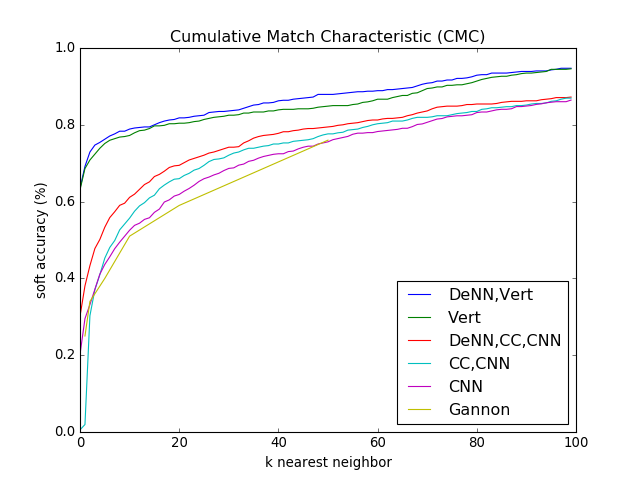

0.52777777777777779

In [83]:
gannonx = [1, 2, 5, 10, 20, 50]
gannony = [0.25, 0.34, 0.40, 0.51, 0.59, 0.76]

plt.figure()
plt.plot(cleanvert)
# for result in results:
#     plt.plot(result)
plt.plot(results[0])
plt.plot(patnetclean)
plt.plot(patnet)
plt.plot(x)
plt.plot(gannonx,gannony)

plt.xlabel('k nearest neighbor')
plt.ylabel('soft accuracy (%)')
plt.title('Cumulative Match Characteristic (CMC)')
plt.legend(['DeNN,Vert', 'Vert', 'DeNN,CC,CNN', 'CC,CNN','CNN','Gannon'],loc=4)
result[0]

<IPython.core.display.Javascript object>


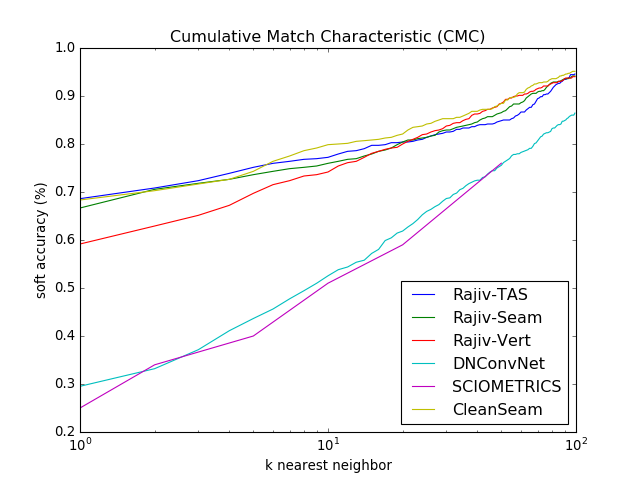

In [58]:
plt.figure()
for result in results:
    plt.semilogx(xrange(100),result)
plt.semilogx(xrange(100),x)
plt.semilogx(gannonx,gannony)
# plt.semilogx(xrange(100),patnet)
plt.semilogx(xrange(100),cleanseam)
plt.xlabel('k nearest neighbor')
plt.ylabel('soft accuracy (%)')
plt.title('Cumulative Match Characteristic (CMC)')
plt.legend(['Rajiv-TAS','Rajiv-Seam','Rajiv-Vert', 'DNConvNet','SCIOMETRICS', 'CleanSeam'],loc=4)